In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json

# LOAD the data

In [2]:
# Get the current notebook's directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
# Go up one level to the project root if needed
project_root = os.path.dirname(current_dir)
# Define paths relative to those locations
bootstrap_res_dir = os.path.join(project_root, 'data_files')
bootstrap_mean_file = 'mean_dict_nature_bootstrap.json'

#load the mean dict and convert it to dictionary with the keys as the model names and the values as the mean values of each prompt style
input_dict = json.load(open(os.path.join(bootstrap_res_dir, bootstrap_mean_file)))

full_bootstrap_dict = json.load(open(os.path.join(bootstrap_res_dir, 'f1_dict_nature_bootstrap.json')))

In [3]:
full_bootstrap_dict['ClinicalResponse']
#get mean, qaurtiles of this full_bootstrap_dict['ClinicalResponse]

mean_clin = int(np.mean(full_bootstrap_dict['ClinicalResponse'])*100)/100
q1_clin = int(np.percentile(full_bootstrap_dict['ClinicalResponse'], 25)*100)/100
q3_clin = int(np.percentile(full_bootstrap_dict['ClinicalResponse'], 75)*100)/100
median_clin = int(np.percentile(full_bootstrap_dict['ClinicalResponse'], 50)*100)/100
print(mean_clin, q1_clin, median_clin, q3_clin)
print(np.log(mean_clin), np.log(q1_clin), np.log(median_clin), np.log(q3_clin))


48.77 46.21 48.79 51.42
3.887115369721961 3.833196224882175 3.8875253738277458 3.9400272018377436


In [4]:
# Prompt styles
prompt_styles = ["Zero-Shot", "Few-Shot", "CoT", "FewShot-CoT", "SC"]
# Mapping of models to their respective prefixes
model_mapping = {
    "GPT-3.5": "gpt-3.5-turbo-1106",
    "GPT-4.0": "gpt-4-1106-preview",
    "Mixtral-8x7B": "mixtral-8x7b-instruct",
    "Qwen-72B": "qwen-72b",
    "LlaMa2-70B": "llama-v2-70b-chat",
    "LlaMa3-70B": "llama-v3-70B-instruct"
}

# Initialize output dictionary
all_models_mean_values = {}
all_models_bootstrap_values = {}

# Populate the output dictionary
for model, prefix in model_mapping.items():
    mean_values = []
    bootstrap_values = []
    for style in ["zero-shot", "5-shot", "zs-cot", "fs-cot", "sc-cot"]:
        key = f"{prefix}_{style}"
        #mean_values.append(round(input_dict.get(key, 0), 2))
        mean_values.append(int(input_dict.get(key, 0) * 100) / 100)
        bootstrap_values.append(full_bootstrap_dict.get(key, 0))
    all_models_mean_values[model] = mean_values
    all_models_bootstrap_values[model] = bootstrap_values

# Result
output_dict = {
    "all_models_mean_values": all_models_mean_values
}

bootstrap_output_dict = {
    "all_models_bootstrap_values": all_models_bootstrap_values
}

# formatting visualization 

Duplicate key in file '/home/mdani31/semioLLM/visualization/.matplotlibrc', line 15 ('font.sans-serif      : Arial, sans-serif')


/tmp/ipykernel_399691/3918998775.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ZS', 'FS', 'CoT', 'FS-CoT', 'SC'])


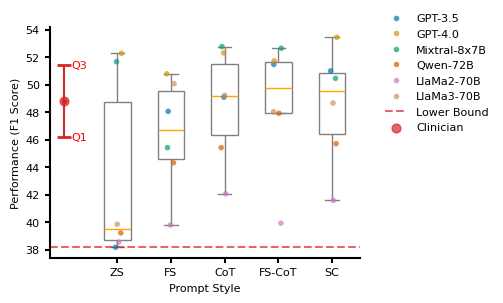

In [6]:
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import matplotlib as mpl

format_file = os.path.join(current_dir, '.matplotlibrc')
with mpl.rc_context(fname=format_file):
# Prepare data for the box plot
    data = {
        "Prompt Style": [],
        "F1 Score": [],
        "Model": []
    }
    # Map full prompt styles to short names
    prompt_style_map = {
        "Zero-Shot": "ZS",
        "Few-Shot": "FS",
        "Chain-of-Thought": "CoT",
        "Few-Shot-CoT": "FS-CoT",
        "Self-Consistency": "SC"
    }

    # Populate the data dictionary
    for model, scores in all_models_mean_values.items():
        for i, score in enumerate(scores):
            data["Prompt Style"].append(prompt_styles[i])
            data["F1 Score"].append(score)
            data["Model"].append(model)

    # Clinicians data
    mean_clinician = int(input_dict['ClinicalResponse'] * 100) / 100
    conf_int = json.load(open(os.path.join(bootstrap_res_dir, 'all_confidence_nature_bootstrap.json')))
    conf_int_clinician = conf_int['ClinicalResponse']
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Plotting a box plot
    plt.figure(figsize=(4, 3))

    ax = sns.boxplot(
        x="Prompt Style", 
        y="F1 Score", 
        data=df, 
        showfliers=False,
        boxprops=dict(facecolor="none", edgecolor="gray"),
        whiskerprops=dict(color="gray"),
        capprops=dict(color="gray"),
        medianprops=dict(color="orange"),
        width=0.5
    )

    # Strip plot
    model_datapoints = sns.stripplot(
        data=df,
        x='Prompt Style',
        y="F1 Score",
        hue = 'Model',
        palette='colorblind',
        size=4,
        jitter=True,
        alpha=0.7
    )
    # Add horizontal line for lower bound
    plt.axhline(y=38.21, color='#d62728', linestyle='--', label='Lower Bound', alpha=0.7)

    # Add red dot for clinician output
    plt.scatter(x=[-1], y=[mean_clinician], color='#d62728', marker='o', s=40, label='Clinician', alpha=0.7)

    plt.errorbar(x=[-1], y=[mean_clinician], yerr=[[mean_clinician - q1_clin], [q3_clin - mean_clinician]], fmt='o', color='#d62728', capsize=5, capthick=2)
    #print Q1 and Q3 at the error bars
    plt.text(-0.56, 46.2, 'Q1', ha='right', va='center', color='r')
    plt.text(-0.56, 51.42, 'Q3', ha='right', va='center', color='r')
    # Legend and labels
    plt.legend(bbox_to_anchor=(1.05, 1.10), loc='upper left')
    plt.ylabel("Performance (F1 Score)")
    ax.set_xticklabels(['ZS', 'FS', 'CoT', 'FS-CoT', 'SC'])
    #plt.tight_layout()
    #despine and remove grid
    sns.despine()
    plt.grid(False)
    #plt.savefig("correctness_score.svg")
    plt.show()
